# Model Training and Evaluation



## 1. Setup and Data Loading

In [110]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Utils functions
import os
import sys

# Add the src directory to Python path to import our utils module
src_path = os.path.abspath("../../src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import feature engineering utilities from our custom module
from utils import confusion_matrix_analysis, analyze_feature_scaling, get_classification_report_table  # type: ignore

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)


# Styling
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("📚 Libraries imported successfully!")
print(f"📍 Working directory: {os.getcwd()}")

📚 Libraries imported successfully!
📍 Working directory: /Users/xaviercoulon/Documents/OC/OC_P4_ESN_TechNova_Partners/notebooks/modeling


In [111]:
# Load preprocessed data
print("LOADING PREPROCESSED DATA:")
print("="*50)

# Define data paths
data_path = "../../data/processed"
X_file = os.path.join(data_path, "X_features.csv")
y_file = os.path.join(data_path, "y_target.csv")

# Load features and target
X = pd.read_csv(X_file)
y = pd.read_csv(y_file).squeeze()  # Convert to Series

print(f"✅ Features loaded: {X.shape}")
print(f"✅ Target loaded: {y.shape}")

print(f"\n📊 Dataset Summary:")
print(f"   Total samples: {len(X)}")
print(f"   Total features: {X.shape[1]}")
print(f"   Target variable: {y.name}")
print(f"   Target classes: {sorted(y.unique())}")
print(f"   Class distribution:")
for class_val in sorted(y.unique()):
    count = (y == class_val).sum()
    percentage = (count / len(y)) * 100
    print(f"     Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\n🎯 Data ready for modeling!")

LOADING PREPROCESSED DATA:
✅ Features loaded: (1470, 42)
✅ Target loaded: (1470,)

📊 Dataset Summary:
   Total samples: 1470
   Total features: 42
   Target variable: a_quitte_l_entreprise
   Target classes: [np.int64(0), np.int64(1)]
   Class distribution:
     Class 0: 1233 (83.9%)
     Class 1: 237 (16.1%)

🎯 Data ready for modeling!


## 2. Analyze feature scaling

In [112]:
analyze_feature_scaling(X)

FEATURE SCALING ANALYSIS:
Numerical features: 42

📊 Key Feature Statistics:
        age  genre  revenu_mensuel  nombre_experiences_precedentes  \
mean  36.92   0.40         6502.93                            2.69   
std    9.14   0.49         4707.96                            2.50   
min   18.00   0.00         1009.00                            0.00   
max   60.00   1.00        19999.00                            9.00   

      annee_experience_totale  annees_dans_l_entreprise  \
mean                    11.28                      7.01   
std                      7.78                      6.13   
min                      0.00                      0.00   
max                     40.00                     40.00   

      annees_dans_le_poste_actuel  satisfaction_employee_environnement  \
mean                         4.23                                 2.72   
std                          3.62                                 1.09   
min                          0.00                      

{'feature_stats':                age        genre  revenu_mensuel  \
 count  1470.000000  1470.000000     1470.000000   
 mean     36.923810     0.400000     6502.931293   
 std       9.135373     0.490065     4707.956783   
 min      18.000000     0.000000     1009.000000   
 25%      30.000000     0.000000     2911.000000   
 50%      36.000000     0.000000     4919.000000   
 75%      43.000000     1.000000     8379.000000   
 max      60.000000     1.000000    19999.000000   
 
        nombre_experiences_precedentes  annee_experience_totale  \
 count                     1470.000000              1470.000000   
 mean                         2.693197                11.279592   
 std                          2.498009                 7.780782   
 min                          0.000000                 0.000000   
 25%                          1.000000                 6.000000   
 50%                          2.000000                10.000000   
 75%                          4.000000      

## 3. Train/Test Split

In [113]:
# Create train/test split
print("TRAIN/TEST SPLIT:")
print("="*50)

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✅ Train set: {X_train.shape}")
print(f"✅ Test set: {X_test.shape}")

print(f"\n📊 Class distribution after split:")
print(f"\nTraining set:")
for class_val in sorted(y_train.unique()):
    count = (y_train == class_val).sum()
    percentage = (count / len(y_train)) * 100
    print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\nTest set:")
for class_val in sorted(y_test.unique()):
    count = (y_test == class_val).sum()
    percentage = (count / len(y_test)) * 100
    print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\n🎯 Stratified split completed!")

TRAIN/TEST SPLIT:
✅ Train set: (1176, 42)
✅ Test set: (294, 42)

📊 Class distribution after split:

Training set:
  Class 0: 986 (83.8%)
  Class 1: 190 (16.2%)

Test set:
  Class 0: 247 (84.0%)
  Class 1: 47 (16.0%)

🎯 Stratified split completed!


## 4. Baseline Model - DummyClassifier

In [114]:
print("BASELINE MODEL - DUMMYCLASSIFIER WITH FULL CV METRICS:")
print("="*60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dummy_strategies = ['most_frequent', 'stratified', 'uniform']
dummy_results = {}

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro'
}

from typing import Literal, cast

for strategy in dummy_strategies:
    print(f"\n🤖 Testing strategy: {strategy}")
    
    # Cast strategy to the correct Literal type for type checkers
    strategy_literal = cast(Literal['most_frequent', 'prior', 'stratified', 'uniform', 'constant'], strategy)
    dummy = DummyClassifier(strategy=strategy_literal, random_state=42)
    
    # Cross-validation metrics
    cv_scores = {}
    for metric_name, scoring in scoring_metrics.items():
        scores = cross_val_score(dummy, X_train, y_train, cv=cv, scoring=scoring)
        cv_scores[metric_name] = (scores.mean(), scores.std())
    
    # Fit on full training set for test evaluation
    dummy.fit(X_train, y_train)
    y_pred_test = dummy.predict(X_test)
    
    test_scores = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision_weighted': precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred_test, average='weighted'),
        'f1_weighted': f1_score(y_test, y_pred_test, average='weighted'),
        'f1_macro': f1_score(y_test, y_pred_test, average='macro')
    }
    
    # Store results
    dummy_results[strategy] = {
        'cv': cv_scores,
        'test': test_scores
    }
    
    # Display results
    print("   📊 Cross-validation metrics:")
    for metric, (mean, std) in cv_scores.items():
        print(f"      {metric}: {mean:.4f} ± {std:.4f}")
        
    print("   📊 Test set metrics:")
    for metric, value in test_scores.items():
        print(f"      {metric}: {value:.4f}")

# Best strategy based on test F1-macro
best_strategy = max(dummy_results.keys(), key=lambda k: dummy_results[k]['test']['f1_macro'])
best_f1 = dummy_results[best_strategy]['test']['f1_macro']

print(f"\n🏆 Best baseline strategy: {best_strategy}")
print(f"    Test F1-macro: {best_f1:.4f}")

# Classification report
dummy_best = DummyClassifier(strategy=best_strategy, random_state=42)
dummy_best.fit(X_train, y_train)
y_pred_best = dummy_best.predict(X_test)

# Display formatted classification report
print(f"\n📋 Classification Report - DummyClassifier (Best Strategy):")
display(get_classification_report_table(y_test, y_pred_best, "DummyClassifier (Best Strategy)"))

print(f"\n🎯 Baseline established! Any real model should beat test F1-macro={best_f1:.4f}")


BASELINE MODEL - DUMMYCLASSIFIER WITH FULL CV METRICS:

🤖 Testing strategy: most_frequent
   📊 Cross-validation metrics:
      accuracy: 0.8384 ± 0.0003
      precision_weighted: 0.7030 ± 0.0005
      recall_weighted: 0.8384 ± 0.0003
      f1_weighted: 0.7648 ± 0.0004
      f1_macro: 0.4561 ± 0.0001
   📊 Test set metrics:
      accuracy: 0.8401
      precision_weighted: 0.7058
      recall_weighted: 0.8401
      f1_weighted: 0.7671
      f1_macro: 0.4566

🤖 Testing strategy: stratified
   📊 Cross-validation metrics:
      accuracy: 0.7406 ± 0.0093
      precision_weighted: 0.7321 ± 0.0097
      recall_weighted: 0.7406 ± 0.0093
      f1_weighted: 0.7363 ± 0.0095
      f1_macro: 0.5054 ± 0.0178
   📊 Test set metrics:
      accuracy: 0.7143
      precision_weighted: 0.7191
      recall_weighted: 0.7143
      f1_weighted: 0.7167
      f1_macro: 0.4771

🤖 Testing strategy: uniform
   📊 Cross-validation metrics:
      accuracy: 0.7406 ± 0.0093
      precision_weighted: 0.7321 ± 0.0097
      

/Users/xaviercoulon/Documents/OC/OC_P4_ESN_TechNova_Partners/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/xaviercoulon/Documents/OC/OC_P4_ESN_TechNova_Partners/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/xaviercoulon/Documents/OC/OC_P4_ESN_TechNova_Partners/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

,Precision,Recall,F1-Score
Class 0 (Stayed),0.8327,0.8259,0.8293
Class 1 (Left),0.1224,0.1277,0.1250
Accuracy,0.7143,0.7143,0.7143
Macro Average,0.4776,0.4768,0.4771
Weighted Average,0.7191,0.7143,0.7167



🎯 Baseline established! Any real model should beat test F1-macro=0.4771



=== CONFUSION MATRIX ANALYSIS for Dummy Classifier ===
📊 Confusion Matrix:
   True labels (rows) vs Predicted labels (columns)
   Classes: [np.int64(0), np.int64(1)]

[[204  43]
 [ 41   6]]


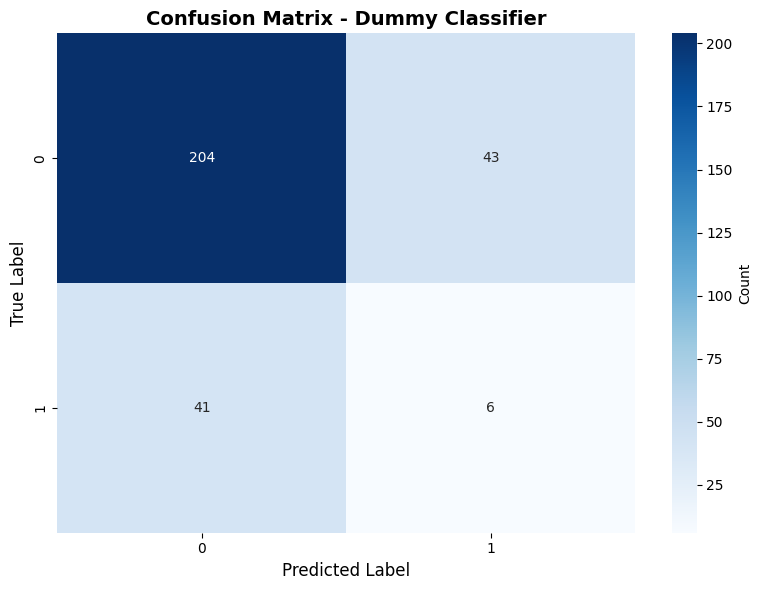


📈 Confusion Matrix Analysis:

   Class 0:
     True Positives:  204
     False Positives: 41
     False Negatives: 43
     True Negatives:  6
     Sensitivity (Recall): 0.8259
     Specificity:          0.1277
     Precision:            0.8327

   Class 1:
     True Positives:  6
     False Positives: 43
     False Negatives: 41
     True Negatives:  204
     Sensitivity (Recall): 0.1277
     Specificity:          0.8259
     Precision:            0.1224

🎯 Confusion Matrix completed!


In [115]:
confusion_matrix_analysis(y_test, y_pred_best, model_name="Dummy Classifier")

## 5. Logistic Regression Model (with StandardScaler Pipeline)

In [116]:
# ----------------------------------------
# LOGISTIC REGRESSION MODEL WITH CROSS-VALIDATION
# ----------------------------------------
print("LOGISTIC REGRESSION MODEL:")
print("="*50)

# --- Create Pipeline (but don't fit yet) ---
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("🤖 Pipeline created with StandardScaler + LogisticRegression")

# --- STEP 1: Cross-validation BEFORE fitting ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro'
}

print("\n🔄 Performing Cross-Validation (fresh models)...")
cv_results = {}
for metric_name, scoring in scoring_metrics.items():
    scores = cross_val_score(lr_pipeline, X_train, y_train, cv=cv, scoring=scoring)
    cv_results[metric_name] = (scores.mean(), scores.std())

# --- STEP 2: Fit on full training set ---
print("🏋️ Fitting on full training set...")
lr_pipeline.fit(X_train, y_train)

# --- STEP 3: Predictions ---
y_pred_train_lr = lr_pipeline.predict(X_train)
y_pred_test_lr = lr_pipeline.predict(X_test)
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)

# --- STEP 4: Calculate metrics ---
# Training metrics
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
precision_train_lr = precision_score(y_train, y_pred_train_lr, average='weighted', zero_division=0)
recall_train_lr = recall_score(y_train, y_pred_train_lr, average='weighted')
f1_train_lr = f1_score(y_train, y_pred_train_lr, average='weighted')
f1_macro_train_lr = f1_score(y_train, y_pred_train_lr, average='macro')

# Test metrics
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
precision_test_lr = precision_score(y_test, y_pred_test_lr, average='weighted', zero_division=0)
recall_test_lr = recall_score(y_test, y_pred_test_lr, average='weighted')
f1_test_lr = f1_score(y_test, y_pred_test_lr, average='weighted')
f1_macro_test_lr = f1_score(y_test, y_pred_test_lr, average='macro')

# --- Display metrics ---
print("\n📊 Logistic Regression Performance:")

print(f"\n   🔄 Cross-Validation Results ({cv.n_splits} folds):")
for metric, (mean, std) in cv_results.items():
    print(f"      {metric}: {mean:.4f} ± {std:.4f}")

print(f"\n   Training Set (Full Fit):")
print(f"      Accuracy:  {accuracy_train_lr:.4f}")
print(f"      Precision: {precision_train_lr:.4f}")
print(f"      Recall:    {recall_train_lr:.4f}")
print(f"      F1-Score:  {f1_train_lr:.4f}")
print(f"      F1-Macro:  {f1_macro_train_lr:.4f}")

print(f"\n   Test Set:")
print(f"      Accuracy:  {accuracy_test_lr:.4f}")
print(f"      Precision: {precision_test_lr:.4f}")
print(f"      Recall:    {recall_test_lr:.4f}")
print(f"      F1-Score:  {f1_test_lr:.4f}")
print(f"      F1-Macro:  {f1_macro_test_lr:.4f}")

# --- Overfitting check ---
f1_diff_lr = f1_train_lr - f1_test_lr
if abs(f1_diff_lr) < 0.01:
    overfitting_status_lr = "✅ Excellent generalization"
elif f1_diff_lr > 0.05:
    overfitting_status_lr = "⚠️ Possible overfitting"
elif f1_diff_lr > 0.02:
    overfitting_status_lr = "⚡ Minor overfitting"
else:
    overfitting_status_lr = "ℹ️ Normal variance"

print(f"\n   🔍 Overfitting Analysis:")
print(f"      Train-Test F1 diff: {f1_diff_lr:+.4f}")
print(f"      Status: {overfitting_status_lr}")

# --- Comparison with baseline ---
print(f"\n🆚 Comparison with best baseline (Test F1={best_f1:.4f}):")
improvement = f1_test_lr - best_f1
if improvement > 0:
    print(f"   ✅ Improvement: +{improvement:.4f} ({(improvement/best_f1)*100:.1f}%)")
else:
    print(f"   ❌ Worse than baseline: {improvement:.4f}")

# --- Classification report ---
print(f"\n📋 Classification Report - Logistic Regression:")
display(get_classification_report_table(y_test, y_pred_test_lr, "Logistic Regression"))

# Importance of features

print("\n📈 Feature Importances (Logistic Regression Coefficients):")

# Récupération du scaler et du modèle depuis le pipeline
scaler = lr_pipeline.named_steps["scaler"]
model = lr_pipeline.named_steps["classifier"]

# Récupération du nom des features (avec les transformations si besoin)
feature_names = X_train.columns

# Récupération des coefficients
coefs = pd.Series(model.coef_[0], index=feature_names)

# Calcul de l’importance absolue
importance_abs = coefs.abs().sort_values(ascending=False)

# Top 15 plus influentes
top_features = importance_abs.head(15)
print("\nTop 15 Features (by absolute coefficient value):")
print(top_features)

# Ajout du signe pour interprétation directionnelle
coef_summary = pd.DataFrame(
    {
        "Feature": coefs.index,
        "Coefficient": coefs.values,
        "Abs_Importance": coefs.abs().values,
    }
).sort_values(by="Abs_Importance", ascending=False)

print("\n🔍 Full coefficient summary (sorted):")
display(coef_summary.head(20))


# --- Save pipeline & model ---
lr_model_pipeline = lr_pipeline
lr_model = lr_pipeline.named_steps['classifier']

LOGISTIC REGRESSION MODEL:
🤖 Pipeline created with StandardScaler + LogisticRegression

🔄 Performing Cross-Validation (fresh models)...
🏋️ Fitting on full training set...

📊 Logistic Regression Performance:

   🔄 Cross-Validation Results (5 folds):
      accuracy: 0.8946 ± 0.0204
      precision_weighted: 0.8876 ± 0.0271
      recall_weighted: 0.8946 ± 0.0204
      f1_weighted: 0.8826 ± 0.0264
      f1_macro: 0.7635 ± 0.0592

   Training Set (Full Fit):
      Accuracy:  0.9048
      Precision: 0.8990
      Recall:    0.9048
      F1-Score:  0.8966
      F1-Macro:  0.7953

   Test Set:
      Accuracy:  0.8639
      Precision: 0.8456
      Recall:    0.8639
      F1-Score:  0.8461
      F1-Macro:  0.6835

   🔍 Overfitting Analysis:
      Train-Test F1 diff: +0.0506
      Status: ⚠️ Possible overfitting

🆚 Comparison with best baseline (Test F1=0.4771):
   ✅ Improvement: +0.3689 (77.3%)

📋 Classification Report - Logistic Regression:
🏋️ Fitting on full training set...

📊 Logistic Regressi

,Precision,Recall,F1-Score
Class 0 (Stayed),0.8848,0.9636,0.9225
Class 1 (Left),0.6400,0.3404,0.4444
Accuracy,0.8639,0.8639,0.8639
Macro Average,0.7624,0.6520,0.6835
Weighted Average,0.8456,0.8639,0.8461



📈 Feature Importances (Logistic Regression Coefficients):

Top 15 Features (by absolute coefficient value):
heure_supplementaires                   0.871219
annee_experience_totale                 0.724477
annees_depuis_la_derniere_promotion     0.547526
frequence_deplacement                   0.531126
satisfaction_employee_environnement     0.485508
delta_evaluation                        0.480129
poste_Consultant                        0.478567
poste_Directeur Technique               0.470582
mobilite_interne_ratio                  0.465580
satisfaction_employee_nature_travail    0.441752
distance_domicile_travail               0.417160
poste_Représentant Commercial           0.406396
age                                     0.372673
domaine_etude_Entrepreunariat           0.365167
statut_marital_Marié(e)                 0.361344
dtype: float64

🔍 Full coefficient summary (sorted):


,Feature,Coefficient,Abs_Importance
13,heure_supplementaires,0.871219,0.871219
4,annee_experience_totale,-0.724477,0.724477
20,annees_depuis_la_derniere_promotion,0.547526,0.547526
19,frequence_deplacement,0.531126,0.531126
7,satisfaction_employee_environnement,-0.485508,0.485508
41,delta_evaluation,0.480129,0.480129
27,poste_Consultant,0.478567,0.478567
28,poste_Directeur Technique,-0.470582,0.470582
39,mobilite_interne_ratio,-0.465580,0.465580
9,satisfaction_employee_nature_travail,-0.441752,0.441752


In [117]:
# Store variables for later comparison (keeping original names for compatibility)
y_pred_lr = y_pred_test_lr
accuracy_lr = accuracy_test_lr
precision_lr = precision_test_lr
recall_lr = recall_test_lr
f1_lr = f1_test_lr

print(f"\n✅ Logistic Regression Pipeline completed!")


✅ Logistic Regression Pipeline completed!



=== CONFUSION MATRIX ANALYSIS for Logistic Regression ===
📊 Confusion Matrix:
   True labels (rows) vs Predicted labels (columns)
   Classes: [np.int64(0), np.int64(1)]

[[238   9]
 [ 31  16]]


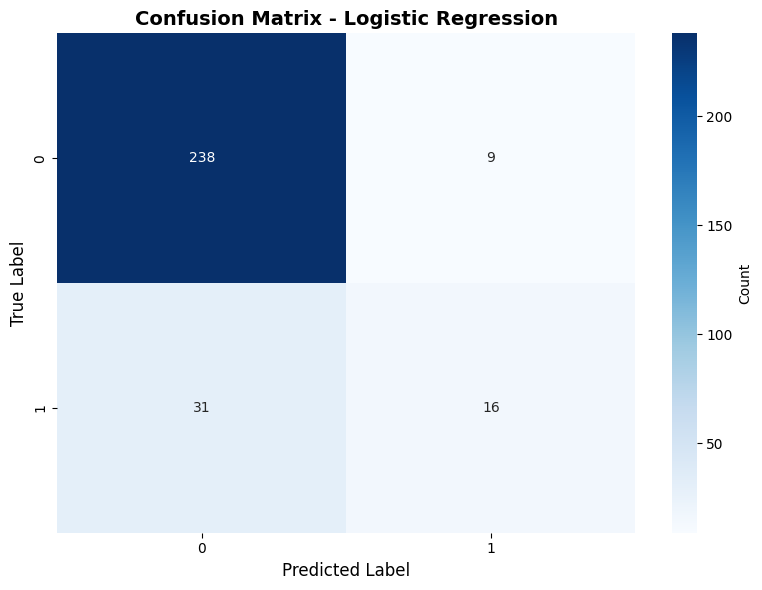


📈 Confusion Matrix Analysis:

   Class 0:
     True Positives:  238
     False Positives: 31
     False Negatives: 9
     True Negatives:  16
     Sensitivity (Recall): 0.9636
     Specificity:          0.3404
     Precision:            0.8848

   Class 1:
     True Positives:  16
     False Positives: 9
     False Negatives: 31
     True Negatives:  238
     Sensitivity (Recall): 0.3404
     Specificity:          0.9636
     Precision:            0.6400

🎯 Confusion Matrix completed!


In [118]:
confusion_matrix_analysis(y_test, y_pred_lr, model_name="Logistic Regression")

## 5. Random Forest Model

In [119]:
# ----------------------------------------
# RANDOM FOREST MODEL WITH CROSS-VALIDATION
# ----------------------------------------
print("RANDOM FOREST MODEL:")
print("=" * 50)

# --- Create Random Forest pipeline ---
rf_pipeline = Pipeline(steps=[("classifier", RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
))])

# --- Cross-validation BEFORE fitting (methodologically correct) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {
    "accuracy": "accuracy",
    "precision_weighted": "precision_weighted",
    "recall_weighted": "recall_weighted",
    "f1_weighted": "f1_weighted",
    "f1_macro": "f1_macro",
}

cv_results_rf = {}
for metric_name, scoring in scoring_metrics.items():
    scores = cross_val_score(
        rf_pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
    )
    cv_results_rf[metric_name] = (scores.mean(), scores.std())

# --- Now fit the model for train/test evaluation ---
rf_model = rf_pipeline.fit(X_train, y_train)

# --- Predictions ---
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# --- Metrics on train set ---
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
precision_train_rf = precision_score(
    y_train, y_pred_train_rf, average="weighted", zero_division=0
)
recall_train_rf = recall_score(y_train, y_pred_train_rf, average="weighted")
f1_train_rf = f1_score(y_train, y_pred_train_rf, average="weighted")
f1_macro_train_rf = f1_score(y_train, y_pred_train_rf, average="macro")

# --- Metrics on test set ---
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
precision_test_rf = precision_score(
    y_test, y_pred_test_rf, average="weighted", zero_division=0
)
recall_test_rf = recall_score(y_test, y_pred_test_rf, average="weighted")
f1_test_rf = f1_score(y_test, y_pred_test_rf, average="weighted")
f1_macro_test_rf = f1_score(y_test, y_pred_test_rf, average="macro")

# --- Display metrics ---
print(f"\n📊 Random Forest Performance:")

print(f"\n   🔄 Cross-Validation (5 folds, train set):")
for metric, (mean, std) in cv_results_rf.items():
    print(f"      {metric}: {mean:.4f} ± {std:.4f}")

print(f"\n   Training Set:")
print(f"      Accuracy:  {accuracy_train_rf:.4f}")
print(f"      Precision: {precision_train_rf:.4f}")
print(f"      Recall:    {recall_train_rf:.4f}")
print(f"      F1-Score:  {f1_train_rf:.4f}")
print(f"      F1-Macro:  {f1_macro_train_rf:.4f}")

print(f"\n   Test Set:")
print(f"      Accuracy:  {accuracy_test_rf:.4f}")
print(f"      Precision: {precision_test_rf:.4f}")
print(f"      Recall:    {recall_test_rf:.4f}")
print(f"      F1-Score:  {f1_test_rf:.4f}")
print(f"      F1-Macro:  {f1_macro_test_rf:.4f}")

# --- Overfitting check ---
f1_diff_rf = f1_train_rf - f1_test_rf
if abs(f1_diff_rf) < 0.01:
    overfitting_status_rf = "✅ Excellent generalization"
elif f1_diff_rf > 0.10:
    overfitting_status_rf = "🚨 Significant overfitting"
elif f1_diff_rf > 0.05:
    overfitting_status_rf = "⚠️ Moderate overfitting"
elif f1_diff_rf > 0.02:
    overfitting_status_rf = "⚡ Minor overfitting"
else:
    overfitting_status_rf = "ℹ️ Normal variance"

print(f"\n   🔍 Overfitting Analysis:")
print(f"      Train-Test F1 diff: {f1_diff_rf:+.4f}")
print(f"      Status: {overfitting_status_rf}")

if f1_diff_rf > 0.05:
    print(f"      💡 Consider: Reduce max_depth, increase min_samples_split/leaf")

# --- Comparison with baseline ---
print(f"\n🆚 Comparison with best baseline (Test F1={best_f1:.4f}):")
improvement_rf = f1_test_rf - best_f1
if improvement_rf > 0:
    print(
        f"   ✅ Improvement: +{improvement_rf:.4f} ({(improvement_rf/best_f1)*100:.1f}%)"
    )
else:
    print(f"   ❌ Worse than baseline: {improvement_rf:.4f}")

# --- Classification report ---
print(f"\n📋 Classification Report - Random Forest:")
display(get_classification_report_table(y_test, y_pred_test_rf, "Random Forest"))

# --- Feature importance ---
print(f"\n🔍 Top 10 Most Important Features:")
feature_importance = pd.DataFrame(
    {"feature": X.columns, "importance": rf_model.named_steps["classifier"].feature_importances_}
).sort_values("importance", ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:<25} : {row['importance']:.4f}")

print(f"\n🌲 Random Forest training completed!")

# --- Save model ---
rf_model_pipeline = rf_model  # Pour compatibilité future

RANDOM FOREST MODEL:

📊 Random Forest Performance:

   🔄 Cross-Validation (5 folds, train set):
      accuracy: 0.8520 ± 0.0123
      precision_weighted: 0.8392 ± 0.0191
      recall_weighted: 0.8520 ± 0.0123
      f1_weighted: 0.8430 ± 0.0174
      f1_macro: 0.6950 ± 0.0425

   Training Set:
      Accuracy:  0.9286
      Precision: 0.9295
      Recall:    0.9286
      F1-Score:  0.9290
      F1-Macro:  0.8698

   Test Set:
      Accuracy:  0.8163
      Precision: 0.8132
      Recall:    0.8163
      F1-Score:  0.8147
      F1-Macro:  0.6521

   🔍 Overfitting Analysis:
      Train-Test F1 diff: +0.1143
      Status: 🚨 Significant overfitting
      💡 Consider: Reduce max_depth, increase min_samples_split/leaf

🆚 Comparison with best baseline (Test F1=0.4771):
   ✅ Improvement: +0.3376 (70.7%)

📋 Classification Report - Random Forest:

📊 Random Forest Performance:

   🔄 Cross-Validation (5 folds, train set):
      accuracy: 0.8520 ± 0.0123
      precision_weighted: 0.8392 ± 0.0191
      

,Precision,Recall,F1-Score
Class 0 (Stayed),0.8876,0.8947,0.8911
Class 1 (Left),0.4222,0.4043,0.4130
Accuracy,0.8163,0.8163,0.8163
Macro Average,0.6549,0.6495,0.6521
Weighted Average,0.8132,0.8163,0.8147



🔍 Top 10 Most Important Features:
    1. ratio_anciennete          : 0.0908
    2. age                       : 0.0804
    3. heure_supplementaires     : 0.0758
    4. revenu_mensuel            : 0.0750
    5. annee_experience_totale   : 0.0679
    6. annees_dans_l_entreprise  : 0.0505
    7. nombre_participation_pee  : 0.0486
    8. annes_sous_responsable_actuel : 0.0440
    9. niveau_hierarchique_poste : 0.0410
   10. mobilite_interne_ratio    : 0.0353

🌲 Random Forest training completed!



=== CONFUSION MATRIX ANALYSIS for Random Forest ===
📊 Confusion Matrix:
   True labels (rows) vs Predicted labels (columns)
   Classes: [np.int64(0), np.int64(1)]

[[221  26]
 [ 28  19]]


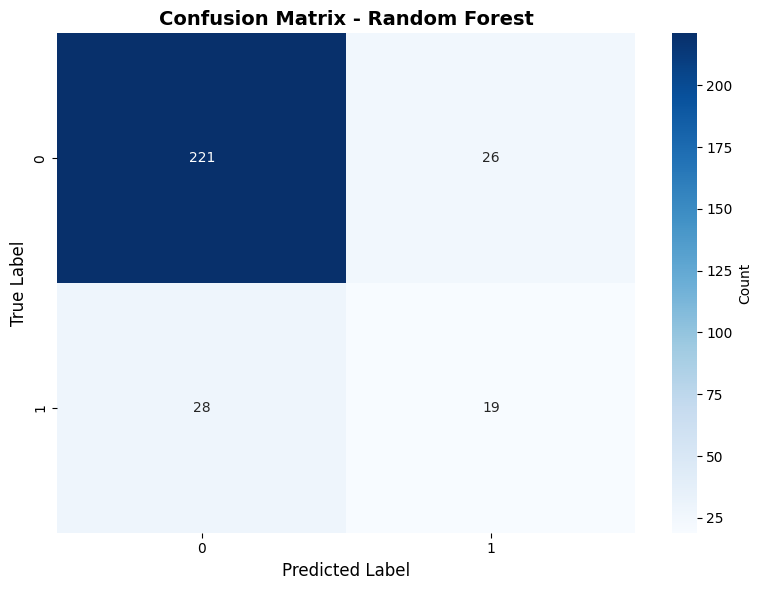


📈 Confusion Matrix Analysis:

   Class 0:
     True Positives:  221
     False Positives: 28
     False Negatives: 26
     True Negatives:  19
     Sensitivity (Recall): 0.8947
     Specificity:          0.4043
     Precision:            0.8876

   Class 1:
     True Positives:  19
     False Positives: 26
     False Negatives: 28
     True Negatives:  221
     Sensitivity (Recall): 0.4043
     Specificity:          0.8947
     Precision:            0.4222

🎯 Confusion Matrix completed!


In [120]:
confusion_matrix_analysis(y_test, y_pred_test_rf, model_name="Random Forest")

In [121]:
# Store variables for later comparison (keeping original names for compatibility)
y_pred_rf = y_pred_test_rf
accuracy_rf = accuracy_test_rf
precision_rf = precision_test_rf
recall_rf = recall_test_rf
f1_rf = f1_test_rf

print(f"\n✅ Random Forest Pipeline completed!")


✅ Random Forest Pipeline completed!


## 6. Model Comparison and Selection

In [ ]:
# ================================================
# COMPREHENSIVE MODEL COMPARISON WITH CV RESULTS
# ================================================
print("MODEL COMPARISON AND SELECTION:")
print("="*50)

# Prepare comprehensive comparison data
models_summary = {
    "DummyClassifier (Baseline)": {
        "cv": dummy_results[best_strategy]["cv"],
        "test": dummy_results[best_strategy]["test"],
        "strategy": best_strategy,
    },
    "Logistic Regression": {
        "cv": cv_results,
        "test": {
            "accuracy": accuracy_test_lr,
            "precision_weighted": precision_test_lr,
            "recall_weighted": recall_test_lr,
            "f1_weighted": f1_test_lr,
            "f1_macro": f1_macro_test_lr,
        },
    },
    "Random Forest": {
        "cv": cv_results_rf,
        "test": {
            "accuracy": accuracy_test_rf,
            "precision_weighted": precision_test_rf,
            "recall_weighted": recall_test_rf,
            "f1_weighted": f1_test_rf,
            "f1_macro": f1_macro_test_rf,
        },
    },
}

# ================================================
# DETAILED COMPARISON TABLE
# ================================================
print("\n📊 DETAILED MODEL COMPARISON:")
print("-" * 80)
print(f"{'Model':<20} {'CV F1-Weighted':<15} {'CV F1-Macro':<12} {'Test F1-Weighted':<16} {'Test F1-Macro':<12} {'CV Stability':<12}")
print("-" * 80)

model_rankings = []

for model_name, results in models_summary.items():
    # Now we can use the proper f1_weighted key
    cv_f1_weighted = results['cv'].get('f1_weighted', (0, 0))
    cv_f1_macro = results['cv'].get('f1_macro', (0, 0))
    
    test_f1_weighted = results['test'].get('f1_weighted', results['test'].get('f1_score', 0))
    test_f1_macro = results['test'].get('f1_macro', 0)
    
    cv_stability = cv_f1_weighted[1] if isinstance(cv_f1_weighted, tuple) else 0
    
    # Stability assessment
    if cv_stability < 0.01:
        stability_emoji = "✅"
    elif cv_stability < 0.02:
        stability_emoji = "👍"
    elif cv_stability < 0.05:
        stability_emoji = "⚠️"
    else:
        stability_emoji = "🚨"
    
    print(f"{model_name:<20} "
          f"{cv_f1_weighted[0] if isinstance(cv_f1_weighted, tuple) else cv_f1_weighted:<15.4f} "
          f"{cv_f1_macro[0] if isinstance(cv_f1_macro, tuple) else cv_f1_macro:<12.4f} "
          f"{test_f1_weighted:<16.4f} "
          f"{test_f1_macro:<12.4f} "
          f"{stability_emoji} {cv_stability:<10.4f}")
    
    # Store for ranking
    model_rankings.append({
        'name': model_name,
        'cv_f1_weighted': cv_f1_weighted[0] if isinstance(cv_f1_weighted, tuple) else cv_f1_weighted,
        'test_f1_weighted': test_f1_weighted,
        'cv_f1_macro': cv_f1_macro[0] if isinstance(cv_f1_macro, tuple) else cv_f1_macro,
        'test_f1_macro': test_f1_macro,
        'stability': cv_stability
    })

# ================================================
# MODEL RANKING AND SELECTION
# ================================================
print(f"\n🏆 MODEL RANKING:")
print("-" * 50)

# Rank by test F1-weighted (primary metric)
model_rankings.sort(key=lambda x: x['test_f1_weighted'], reverse=True)

print("📈 By Test F1-Weighted Score:")
for i, model in enumerate(model_rankings, 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {medal} {model['name']:<25}: {model['test_f1_weighted']:.4f}")

# Rank by CV F1-weighted (reliability check)
model_rankings_cv = sorted(model_rankings, key=lambda x: x['cv_f1_weighted'], reverse=True)
print("\n🔄 By CV F1-Weighted Score (Training Reliability):")
for i, model in enumerate(model_rankings_cv, 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    print(f"   {medal} {model['name']:<25}: {model['cv_f1_weighted']:.4f}")

# ================================================
# BEST MODEL SELECTION
# ================================================
best_model = model_rankings[0]  # Best by test F1-weighted
best_model_name = best_model['name']

print(f"\n🎯 FINAL MODEL SELECTION:")
print(f"   Best Model: {best_model_name}")
print(f"   Test F1-Weighted: {best_model['test_f1_weighted']:.4f}")
print(f"   CV F1-Weighted: {best_model['cv_f1_weighted']:.4f}")
print(f"   CV Stability (std): {best_model['stability']:.4f}")

# Performance improvement over baseline
baseline_perf = [m for m in model_rankings if 'Dummy' in m['name']][0]['test_f1_weighted']
improvement = best_model['test_f1_weighted'] - baseline_perf

if best_model['test_f1_weighted'] > baseline_perf:
    if baseline_perf > 0:
        improvement_pct = (improvement / baseline_perf) * 100
        print(f"   📈 Improvement over baseline: +{improvement:.4f} ({improvement_pct:.1f}%)")
    else:
        print(f"   📈 Improvement over baseline: +{improvement:.4f} (baseline was 0.0000)")
elif improvement == 0:
    print(f"   🟰 Same performance as baseline: {best_model['test_f1_weighted']:.4f}")
else:
    print(f"   ⚠️ Performance issue: Model performs worse than baseline by {abs(improvement):.4f}!")

# ================================================
# OVERFITTING ANALYSIS
# ================================================
print(f"\n🔍 OVERFITTING ANALYSIS:")
print("-" * 30)

for model in model_rankings:
    cv_test_diff = model['cv_f1_weighted'] - model['test_f1_weighted']
    
    if abs(cv_test_diff) < 0.01:
        status = "✅ Excellent generalization"
    elif cv_test_diff > 0.05:
        status = "⚠️ Possible overfitting"
    elif cv_test_diff > 0.02:
        status = "⚡ Minor overfitting"
    elif cv_test_diff < -0.02:
        status = "📉 Underfitting"
    else:
        status = "👍 Good generalization"
    
    print(f"{model['name']:<25}: CV-Test diff = {cv_test_diff:+.4f} → {status}")

print(f"\n✅ Model comparison completed!")
print(f"🎯 Recommended model: {best_model_name}")

# Store results for potential further use
comparison_results = {
    'best_model': best_model_name,
    'rankings': model_rankings,
    'summary': models_summary
}

MODEL COMPARISON AND SELECTION:

📊 DETAILED MODEL COMPARISON:
--------------------------------------------------------------------------------
Model                CV F1-Weighted  CV F1-Macro  Test F1-Weighted Test F1-Macro CV Stability
--------------------------------------------------------------------------------
DummyClassifier (Baseline) 0.7363          0.5054       0.7167           0.4771       ✅ 0.0095    
Logistic Regression  0.8826          0.7635       0.8461           0.6835       ⚠️ 0.0264    
Random Forest        0.8430          0.6950       0.8147           0.6521       👍 0.0174    

🏆 MODEL RANKING:
--------------------------------------------------
📈 By Test F1-Weighted Score:
   🥇 Logistic Regression      : 0.8461
   🥈 Random Forest            : 0.8147
   🥉 DummyClassifier (Baseline): 0.7167

🔄 By CV F1-Weighted Score (Training Reliability):
   🥇 Logistic Regression      : 0.8826
   🥈 Random Forest            : 0.8430
   🥉 DummyClassifier (Baseline): 0.7363

🎯 FINAL MO

## 7. Detailed Performance Analysis by Class



In [123]:
# ================================================
# DETAILED PERFORMANCE ANALYSIS BY CLASS
# ================================================
print("DETAILED PERFORMANCE ANALYSIS BY CLASS:")
print("="*60)

# Collect predictions from all models
model_predictions = {
    'DummyClassifier (Baseline)': y_pred_best,
    'Logistic Regression': y_pred_test_lr,
    'Random Forest': y_pred_test_rf
}

# Class labels mapping
class_labels = {0: "Stayed (Class 0)", 1: "Left (Class 1)"}

print(f"\n📊 CLASS DISTRIBUTION IN TEST SET:")
print("-" * 40)
test_class_counts = y_test.value_counts().sort_index()
for class_val, count in test_class_counts.items():
    percentage = (count / len(y_test)) * 100
    print(f"   {class_labels[class_val]:<20}: {count:3d} samples ({percentage:.1f}%)")

# ================================================
# PER-CLASS METRICS FOR EACH MODEL
# ================================================
print(f"\n📈 PER-CLASS PERFORMANCE METRICS:")
print("="*60)

for model_name, y_pred in model_predictions.items():
    print(f"\n🔸 {model_name}:")
    print("-" * 50)
    
    # Calculate per-class metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Display metrics for each class
    for class_val in [0, 1]:
        class_str = str(class_val)
        if class_str in report:
            metrics = report[class_str]
            print(f"\n   {class_labels[class_val]}:")
            print(f"      Precision: {metrics['precision']:.4f}")
            print(f"      Recall:    {metrics['recall']:.4f}")
            print(f"      F1-Score:  {metrics['f1-score']:.4f}")
            print(f"      Support:   {metrics['support']:.0f} samples")
    
    # Overall metrics
    print(f"\n   📊 Overall Performance:")
    print(f"      Accuracy:     {report['accuracy']:.4f}")
    print(f"      Macro Avg F1: {report['macro avg']['f1-score']:.4f}")
    print(f"      Weighted F1:  {report['weighted avg']['f1-score']:.4f}")

# ================================================
# CLASS-SPECIFIC COMPARISON TABLE
# ================================================
print(f"\n🔍 CLASS-SPECIFIC COMPARISON ACROSS MODELS:")
print("="*70)

# Create comparison table for each class
for class_val in [0, 1]:
    print(f"\n📊 {class_labels[class_val]} Performance:")
    print("-" * 55)
    print(f"{'Model':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 55)
    
    class_comparisons = []
    
    for model_name, y_pred in model_predictions.items():
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        class_str = str(class_val)
        
        if class_str in report:
            metrics = report[class_str]
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1-score']
            
            print(f"{model_name:<25} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")
            
            class_comparisons.append({
                'model': model_name,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
    
    # Find best model for this class
    if class_comparisons:
        best_f1_model = max(class_comparisons, key=lambda x: x['f1'])
        best_recall_model = max(class_comparisons, key=lambda x: x['recall'])
        
        print(f"\n   🏆 Best F1-Score:  {best_f1_model['model']} ({best_f1_model['f1']:.4f})")
        print(f"   🎯 Best Recall:    {best_recall_model['model']} ({best_recall_model['recall']:.4f})")

# ================================================
# CONFUSION MATRIX COMPARISON
# ================================================
print(f"\n🔍 CONFUSION MATRIX COMPARISON:")
print("="*50)

for model_name, y_pred in model_predictions.items():
    print(f"\n🔸 {model_name}:")
    cm = confusion_matrix(y_test, y_pred)
    
    print("   Confusion Matrix:")
    print(f"               Predicted")
    print(f"             Stayed  Left")
    print(f"   Actual Stayed  {cm[0,0]:3d}   {cm[0,1]:3d}")
    print(f"          Left    {cm[1,0]:3d}   {cm[1,1]:3d}")
    
    # Calculate derived metrics
    if len(cm) == 2 and cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate rates
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall for Class 1)
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Recall for Class 0)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
        
        print(f"\n   📊 Key Rates:")
        print(f"      True Positive Rate (Sensitivity):  {tpr:.4f}")
        print(f"      True Negative Rate (Specificity):  {tnr:.4f}")
        print(f"      False Positive Rate:               {fpr:.4f}")
        print(f"      False Negative Rate:               {fnr:.4f}")

# ================================================
# BUSINESS IMPACT ANALYSIS
# ================================================
print(f"\n💼 BUSINESS IMPACT ANALYSIS:")
print("="*50)

print(f"\n📈 Key Business Metrics:")
print("-" * 30)

for model_name, y_pred in model_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    if len(cm) == 2 and cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        # Business interpretations
        correctly_identified_leavers = tp
        missed_leavers = fn
        false_alarms = fp
        correctly_identified_stayers = tn
        
        total_actual_leavers = tp + fn
        total_actual_stayers = tn + fp
        
        print(f"\n🔸 {model_name}:")
        print(f"   Correctly identified employees who left:  {correctly_identified_leavers}/{total_actual_leavers} ({(correctly_identified_leavers/total_actual_leavers)*100:.1f}%)")
        print(f"   Missed employees who left:                {missed_leavers}/{total_actual_leavers} ({(missed_leavers/total_actual_leavers)*100:.1f}%)")
        print(f"   False alarms (predicted left but stayed): {false_alarms}/{total_actual_stayers} ({(false_alarms/total_actual_stayers)*100:.1f}%)")
        
        # Cost-benefit consideration
        if total_actual_leavers > 0:
            prevention_success_rate = correctly_identified_leavers / total_actual_leavers
            print(f"   Potential intervention success rate:       {prevention_success_rate:.1%}")

print(f"\n✅ Detailed class-specific analysis completed!")
print(f"💡 Use these insights to understand which employees your model identifies best.")

DETAILED PERFORMANCE ANALYSIS BY CLASS:

📊 CLASS DISTRIBUTION IN TEST SET:
----------------------------------------
   Stayed (Class 0)    : 247 samples (84.0%)
   Left (Class 1)      :  47 samples (16.0%)

📈 PER-CLASS PERFORMANCE METRICS:

🔸 DummyClassifier (Baseline):
--------------------------------------------------

   Stayed (Class 0):
      Precision: 0.8327
      Recall:    0.8259
      F1-Score:  0.8293
      Support:   247 samples

   Left (Class 1):
      Precision: 0.1224
      Recall:    0.1277
      F1-Score:  0.1250
      Support:   47 samples

   📊 Overall Performance:
      Accuracy:     0.7143
      Macro Avg F1: 0.4771
      Weighted F1:  0.7167

🔸 Logistic Regression:
--------------------------------------------------

   Stayed (Class 0):
      Precision: 0.8848
      Recall:    0.9636
      F1-Score:  0.9225
      Support:   247 samples

   Left (Class 1):
      Precision: 0.6400
      Recall:    0.3404
      F1-Score:  0.4444
      Support:   47 samples

   📊 Ove